# Is Deep Learning *slipping* [on the shoulders of Giants](https://www.wikiwand.com/en/Standing_on_the_shoulders_of_giants)?
### A *critical* reproducibility challenge for [[Rumelhart et al., 1986]](https://sci-hub.se/10.1038/323533a0)

*TO BE FILLED*

Explain why and when it all started...

#### Imports

In [1]:
# Type hints
from typing import Iterable, List, Tuple
from torch import Tensor

# Tensors and NNs
import torch as th
from ebtorch.nn import FCBlock  # API for fully-connected NN blocks
from torch import nn
import torch.nn.functional as F

# Optimizers
import torch.optim as optim

# Tensor data[sets|loader]s
from torch.utils.data import TensorDataset, DataLoader

# Iterable handling
from itertools import product
from copy import deepcopy

# Utilities for callables
from ebtorch.nn.utils import argser_f, emplace_kv

# Plotting
import matplotlib.pyplot as plt

#### Datasets

In [2]:
# The algorithmic function (symmetry-detection for 6-sized binary inputs) we
# want to approximate with a NN
def is_symmetric(iterable: Iterable) -> float:
    assert len(iterable) == 6
    if (
        # iterable[0:3] == iterable[5:2:-1] still unsupported for PyTorch tensors
        iterable[0] == iterable[-1]
        and iterable[1] == iterable[-2]
        and iterable[2] == iterable[-3]
    ):
    # 1 == Yes | 0 == No
        return 1.0
    return 0.0

In [3]:
# We split the dataset output-wise early on, to be able to balance it later in
# case we need to.

x_all: List[Tuple[float]] = [item for item in product([0.0, 1.0], repeat=6)]
x_symmetric: List[Tuple[float]] = [item for item in x_all if is_symmetric(item)]
x_non_symmetric: List[Tuple[float]] = [item for item in set(x_all).difference(set(x_symmetric))]

# And we tensorize it
del x_all
x_symmetric: Tensor = th.tensor(x_symmetric, dtype=th.float32)
x_non_symmetric: Tensor = th.tensor(x_non_symmetric, dtype=th.float32)

In [4]:
# The unbalanced dataset tensor
x: Tensor = th.cat((x_non_symmetric, x_symmetric), dim=0)
y: Tensor = th.tensor([[is_symmetric(sub_x)] for sub_x in x])

# And the balanced one
balancing_ratio: int = int((x_non_symmetric.shape[0]/x_symmetric.shape[0]))
x_balanced: Tensor = th.cat((x_non_symmetric, th.cat([x_symmetric]*balancing_ratio, dim=0)), dim=0)
y_balanced: Tensor = th.tensor([[is_symmetric(sub_x)] for sub_x in x_balanced])
del balancing_ratio

In [5]:
# Conversion to proper PyTorch data[set|loader]s

# Datasets
train_unbalanced_ds = TensorDataset(x, y)
train_balanced_ds = TensorDataset(x_balanced, y_balanced)

# Dataloaders (we do full-dataset-batching as in the paper)
train_unbalanced_dl = DataLoader(train_unbalanced_ds, batch_size=len(train_unbalanced_ds), shuffle=True)
train_balanced_dl = DataLoader(train_balanced_ds, batch_size=len(train_balanced_ds), shuffle=True)

#### Models

In [6]:
# Model constants
MODEL_IN_SIZES: List[int] = [6, 2]
MODEL_OUT_SIZE: int = 1
MODEL_BIAS: bool = True
MODEL_DROPOUT: bool = False
MODEL_BATCHNORM: bool = False

# Model definition

model_original = FCBlock(
    in_sizes=MODEL_IN_SIZES,
    out_size=MODEL_OUT_SIZE,
    bias=MODEL_BIAS,
    activation_fx=nn.Sigmoid(),
    dropout=MODEL_DROPOUT,
    batchnorm=MODEL_BATCHNORM
)

model_modern_init = FCBlock(
    in_sizes=MODEL_IN_SIZES,
    out_size=MODEL_OUT_SIZE,
    bias=MODEL_BIAS,
    activation_fx=nn.Sigmoid(),
    dropout=MODEL_DROPOUT,
    batchnorm=MODEL_BATCHNORM
)

model_improved = FCBlock(
    in_sizes=MODEL_IN_SIZES,
    out_size=MODEL_OUT_SIZE,
    bias=MODEL_BIAS,
    activation_fx=[nn.Tanh(), nn.Sigmoid()],
    dropout=MODEL_DROPOUT,
    batchnorm=MODEL_BATCHNORM
)

model_relu = FCBlock(
    in_sizes=MODEL_IN_SIZES,
    out_size=MODEL_OUT_SIZE,
    bias=MODEL_BIAS,
    activation_fx=[nn.ReLU(), nn.Sigmoid()],
    dropout=MODEL_DROPOUT,
    batchnorm=MODEL_BATCHNORM
)

model_mish = FCBlock(
    in_sizes=MODEL_IN_SIZES,
    out_size=MODEL_OUT_SIZE,
    bias=MODEL_BIAS,
    activation_fx=[nn.Mish(), nn.Sigmoid()],
    dropout=MODEL_DROPOUT,
    batchnorm=MODEL_BATCHNORM
)

In [7]:
# Model initialization functions

def original_init_(model, extrema: Tuple[float]) -> None:
    for name, param in model.named_parameters():
        if name.endswith("weight"):
            nn.init.uniform_(param, a=extrema[0], b=extrema[1])
        if name.endswith("bias"):
            nn.init.zeros_(param)

def modern_init_(model) -> None:
    # Already the default in PyTorch
    # I.e.: Weights -> Kaiming | Bias -> Uniform with weight-dependent extrema
    # See: https://github.com/pytorch/pytorch/blob/7c2103ad5ffdc1ef91231c966988f7f2a61b4166/torch/nn/modules/linear.py#L92
    model.reset_parameters()

In [8]:
# Model initialization
original_init_(model_original, extrema=(-0.3, 0.3))
modern_init_(model_modern_init)
modern_init_(model_improved)
modern_init_(model_relu)
modern_init_(model_mish)

#### Training

In [9]:
# Run training until (hopeful) convergence; gather statistics

def train_diag_aio(model, dataloader, max_epochs_nr: int, loss, optimizer_fx, optimizer_dict, device):
    
    optimizer_params = emplace_kv(optimizer_dict, "params", model.parameters())
    optimizer = argser_f(optimizer_fx, optimizer_params)()

    losses = []
    accuracies = []
    has_converged = []
    
    # Move model to device
    model = model.to(device)
    
    # Put model in training mode
    model.train()
    
    # Iterate over epochs
    for epoch in range(max_epochs_nr):
        
        # Iterate over batches
        # (in our case: batch == dataset)
        for x, y in dataloader:
            
            # Move batch to device
            x, y = x.to(device), y.to(device)
            
            # Forward pass
            optimizer.zero_grad()
            y_hat = model(x)
            loss_value = loss(y_hat, y)
            
            # STATISTICS COMPUTATION
            # Here is fine, since batch == dataset
            with th.no_grad():
                pred = th.round(model(x))
                accuracy = ((pred.eq(y.view_as(pred))).sum().item() / len(x))
                converged = int(accuracy == 1.0)

            losses.append(loss_value.item())
            accuracies.append(accuracy)
            has_converged.append(converged)
            
            # Backward pass
            loss_value.backward()
            optimizer.step()
    
    model.eval()
    
    return tuple(deepcopy(losses)), tuple(deepcopy(accuracies)), tuple(deepcopy(has_converged))

#### Analysis

In [10]:
MAX_EPOCHS_NR = int(4e4)
LOSS = F.mse_loss
OPTIMIZER_FX = optim.SGD
OPTIMIZER_PARAMS = {"params": None, "lr": 0.1, "momentum": 0.9}
DEVICE = "cpu"

In [11]:
l, a, c = train_diag_aio(model_mish, train_balanced_dl, MAX_EPOCHS_NR, LOSS, OPTIMIZER_FX, OPTIMIZER_PARAMS, DEVICE)

In [12]:
print(f"FINAL LOSS: {l[-1]}")
print(f"FINAL ACCURACY: {a[-1]}")

if not c[-1]:
    print("NOT CONVERGED")
else:
    print(f"CONVERGED AT EPOCH {c.index(1)} WITH LOSS {l[c.index(1)]}")

FINAL LOSS: 0.00018631121201906353
FINAL ACCURACY: 1.0
CONVERGED AT EPOCH 4072 WITH LOSS 0.016385972499847412


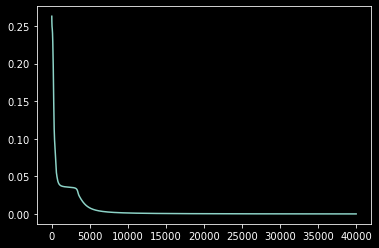

In [13]:
plt.plot(l)

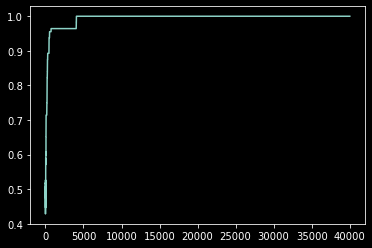

In [14]:
plt.plot(a)

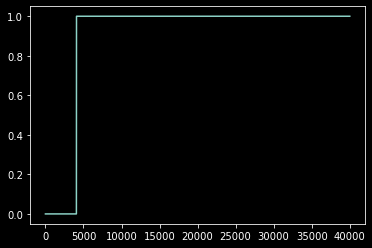

In [15]:
plt.plot(c)